# Fine-tuning BERT for text classification on Quora Dataset using TensorFlow and TF-Hub.

 - build tensorflow input pipelines for text data with tf.data API
 - tokenize and preprocess text for BERT
 - fine-tune BERT for text classification using TensorFlow 2 and TF Hub.


In [ ]:
!nvidia-smi

Sun Apr 18 04:24:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

We need to clone the official tensorflow's models repository.

In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 507), reused 1382 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.01 MiB | 19.30 MiB/s, done.
Resolving deltas: 100% (507/507), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



We also need to install some requirements to use this repository.

In [ ]:
!pip install -Uqr models/official/requirements.txt

     |████████████████████████████████| 7.0MB 6.0MB/s 
     |████████████████████████████████| 225kB 62.3MB/s 
     |████████████████████████████████| 15.3MB 365kB/s 
     |████████████████████████████████| 9.9MB 56.1MB/s 
     |████████████████████████████████| 296kB 64.9MB/s 
     |████████████████████████████████| 102kB 12.5MB/s 
     |████████████████████████████████| 27.4MB 1.3MB/s 
     |████████████████████████████████| 174kB 62.9MB/s 
     |████████████████████████████████| 3.7MB 49.1MB/s 
     |████████████████████████████████| 706kB 49.8MB/s 
     |████████████████████████████████| 358kB 46.9MB/s 
     |████████████████████████████████| 1.2MB 38.9MB/s 
     |████████████████████████████████| 2.0MB 45.2MB/s 
     |████████████████████████████████| 10.3MB 39.8MB/s 
     |████████████████████████████████| 37.6MB 70kB/s 
     |████████████████████████████████| 645kB 53.8MB/s 
     |████████████████████████████████| 3.0MB 42.5MB/s 
     |████████████████████████████████| 81kB 9.4M

In [ ]:
# all imports here
import os
import sys
sys.path.append('models')
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
# submodules from cloned repo
from official.nlp import optimization
from official.nlp.bert import tokenization
from official.nlp.data import classifier_data_lib
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Our working dataset is located on my google drive. Let's upload it into google colab.

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Loading our training dataset into pandas' DataFrame.

In [ ]:
df = pd.read_csv("gdrive/MyDrive/train.csv.zip", compression='zip', low_memory=False)
print(f"Number of texts: {df.shape[0]}")

Number of texts: 1306122


Trainin on over the 1M of texts will take too much time, so we will take just a small part os this dataset. But before splitting lets investigate our targets.

     |████████████████████████████████| 13.1MB 3.7MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.4.1
    Uninstalling matplotlib-3.4.1:
      Successfully uninstalled matplotlib-3.4.1


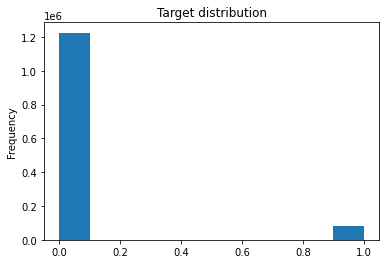

In [ ]:
!pip install matplotlib==3.1.3 # needed for the next line to work
df['target'].plot(kind='hist', title='Target distribution')

Our target classes highly skewed, hence we need stratified splitting.

In [ ]:
train_df, valid_df = train_test_split(df, random_state=42, train_size=.9, stratify=df.target.values)
print(f"Number of training texts: {train_df.shape[0]}")
print(f"Number of validation texts: {valid_df.shape[0]}")
# valid_df, for_test = train_test_split(remaining, random_state=42, train_size=.01, stratify=remaining.target.values)
# print(f"Number of validation texts: {valid_df.shape[0]}")

Number of training texts: 1175509
Number of validation texts: 130613


Now we're going to transform our train/validation DataFrames into tf.data.Datasets

In [ ]:
# making it more efficient to place preprocessing on cpu
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
  validation_data = tf.data.Dataset.from_tensor_slices((valid_df['question_text'].values, valid_df['target'].values))

  for text, label in train_data.take(1):
    print(f"Text: {text}, label: {label}")

Text: b'How effective is a single acupuncture needle for assassinations?', label: 0


The tokenization of input text can be performed in Python with the FullTokenizer class from *tensorflow/models/official/nlp/bert/tokenization.py*. Its vocab_file is stored as a *tf.saved_model.Asset* and the do_lower_case flag is stored as a tf.Variable object on the SavedModel

In [ ]:
label_list = [0, 1]
max_seq_length = 128
train_batch_size = 32

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
# as we use uncased version
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

# Tokenization and preprocessing

First, we create InputExamples using classifier_data_lib's constructor InputExample.

To prevent paying attentions to paddings we use attentions masks.

Dataset.map runs in graph mode:
- Graph tensors do not have a value
- in graph mode you can only use tensorflow ops and functions

We need to wrap our function into tf.py_function. It will pass regular tensors into the function with .numpy()

In [ ]:
# row of data into input features
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid=None, text_a=text.numpy(), text_b=None, label=label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer)
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
      'input_word_ids': input_ids,
      'input_mask': input_mask,
      'input_type_ids': segment_ids
  }

  return (x, label_id)

In [ ]:
# as input objects are independent, the preprocessing can be parallelized
with tf.device('/cpu:0'):
  train_data = (train_data.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
          .shuffle(1000).batch(train_batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))
  
  validation_data = (validation_data.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
          .batch(train_batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
# our input in the following format
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

# Creation of the model

There are two outputs: a **pooled_output** of shape **[batch_size, 768]** with representations for the entire input sequences and a **sequence_output** of shape **[batch_size, max_seq_length, 768]** with representations for each input token (in context).

In [ ]:
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_type_ids")
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
  x = tf.keras.layers.Dense(768, activation='relu')(pooled_output)
  x = tf.keras.layers.Dropout(.2)(x)
  x = tf.keras.layers.Dense(256, activation='relu')(x)
  x = tf.keras.layers.Dropout(.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  x = tf.keras.layers.Dropout(.2)(x)
  output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)
  model = tf.keras.Model(inputs={
      'input_word_ids': input_word_ids,
      'input_mask': input_mask,
      'input_type_ids': input_type_ids
  }, outputs=output)
  return model

Even though for such a skewed classes it's not a good idea to use BinaryAccuracy as our metrics, we'll use it for simplicity. Later we will measure the F1-score on the test set for clear performance measure.

In [ ]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

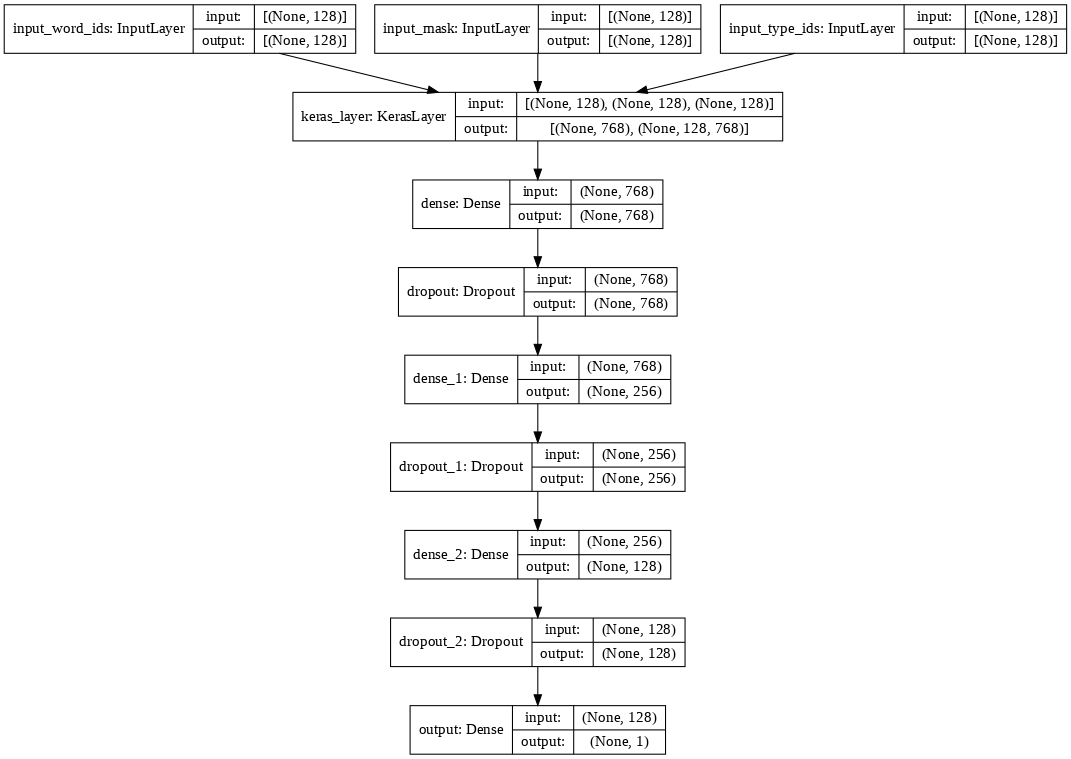

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=76)

In [ ]:
epoch = 1
os.makedirs('saved_models', exist_ok=True)
model_name = 'bert_base_quora.{epoch:03d}.h5'
filepath = os.path.join('saved_models', model_name)
# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True, save_weights_only=True)

callback_list = [checkpoint]

history = model.fit(train_data, validation_data=validation_data, epochs=epoch, callbacks=callback_list)

36734/36734 [==============================] - 10254s 279ms/step - loss: 0.1088 - binary_accuracy: 0.9572 - val_loss: 0.0921 - val_binary_accuracy: 0.9632

Epoch 00001: val_loss improved from inf to 0.09214, saving model to saved_models/bert_base_quora.001.h5


In [ ]:
# test_df, remaining = train_test_split(for_test, train_size=.01, stratify=for_test.target.values)
# print(f"Testing on the {test_df.shape[0]} sentences")

test_data = tf.data.Dataset.from_tensor_slices((valid_df['question_text'], [0]*valid_df.shape[0]))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
threshold = .5
preds = (preds > threshold).flatten().astype('int32')
true_labels = valid_df.target.values
print(len(preds), len(true_labels))

130613 130613


In [ ]:
from sklearn.metrics import f1_score
f1_score(true_labels, preds)

0.6699195931551095

Training on the whole dataset with just 1 epoch we were able to achieve more or less good results. First place on kaggle is 0.71323.

In [ ]:
drive.mount('/content/drive')

gdrive_path = "./drive/MyDrive/"

os.makedirs(gdrive_path, exist_ok=True)

# Copy the model files to a directory in your Google Drive.
!cp -r ./saved_models/ "./drive/My Drive/"

Mounted at /content/drive
